# 🌿 Content-Based Recommenders — **Benchmark Notebook**

**Catatan**: *Content‑Based Filtering (CBF)* adalah **pendekatan/keluarga metode**. Algoritme yang umum dalam keluarga CBF antara lain:
- **TF‑IDF (word/char) + cosine**
- **BM25**
- **LSI / TruncatedSVD (dense) + cosine**
- **SBERT (sentence embeddings) + cosine**
- **UFW (User Feedback Weighting)** di atas TF‑IDF (personalisasi ringan)


## 1) Setup & Instalasi

In [2]:
# !pip -q install -U pandas numpy scipy scikit-learn joblib matplotlib seaborn rank-bm25 sentence-transformers

import os, re, math, sys, json, time, random, warnings, datetime as dt
from pathlib import Path
from typing import List, Optional, Dict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
sns.set_theme(style="whitegrid")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import NearestNeighbors

from scipy.sparse import save_npz
import joblib

try:
    from rank_bm25 import BM25Okapi
    BM25_OK = True
except Exception:
    BM25_OK = False
    warnings.warn("rank-bm25 tidak tersedia. BM25 akan dilewati. Install: pip install rank-bm25")

try:
    from sentence_transformers import SentenceTransformer
    SBERT_OK = True
except Exception:
    SBERT_OK = False
    warnings.warn("sentence-transformers tidak tersedia. SBERT akan dilewati. Install: pip install sentence-transformers")

SEED = 42
random.seed(SEED); np.random.seed(SEED)

BASE_DIR = Path('.')
ART_DIR  = BASE_DIR / 'artifacts_cbf_bench'
ART_DIR.mkdir(exist_ok=True, parents=True)
print('Artifacts directory:', ART_DIR.resolve())


Artifacts directory: /content/artifacts_cbf_bench


/tmp/ipython-input-3990994278.py:30: UserWarning: rank-bm25 tidak tersedia. BM25 akan dilewati. Install: pip install rank-bm25
  warnings.warn("rank-bm25 tidak tersedia. BM25 akan dilewati. Install: pip install rank-bm25")


## 2) Load Data

In [5]:
# Cari file data yang umum digunakan pada proyek ini
CANDIDATES = [Path('.items.csv'), Path('./artifacts/items.csv'), Path('./items.csv')]
data_path = None
for p in CANDIDATES:
    if p.exists():
        data_path = p; break
if data_path is None:
    raise FileNotFoundError("Tidak menemukan eco_place.csv / artifacts/items.csv / items.csv. Upload salah satunya.")

df = pd.read_csv(data_path)
print("Loaded:", data_path, "| Shape:", df.shape)

# Pastikan kolom
for c in ["place_name","place_description","category","city","rating","price","place_img","place_map"]:
    if c not in df.columns: df[c] = np.nan

# Preprocess sederhana (lowercase + filtering stopwords ringan, pertahankan preposisi penting)
STOP = set([
    "ada","adalah","agar","akan","antara","atau","banyak","beberapa","belum","berbagai",
    "bila","bisa","bukan","dalam","dan","dapat","dari","dengan","di","hanya","harus","hingga",
    "ini","itu","jika","juga","kah","kami","kamu","karena","ke","kemudian","kepada","lah","lain",
    "lainnya","lalu","lebih","masih","mereka","mungkin","namun","nya","oleh","pada","para","pernah",
    "pun","saat","saja","sampai","sangat","sebagai","sebuah","seluruh","semua","serta","setiap",
    "suatu","sudah","supaya","tanpa","tapi","tentang","tentu","terhadap","tiap","untuk","yaitu","yakni","yang"
])
KEEP = {"di","ke","dari","untuk","dengan","yang"}

def preprocess_text_simple(text: str) -> str:
    text = str(text).lower()
    toks = re.findall(r"\w+", text)
    toks = [t for t in toks if (t not in STOP) or (t in KEEP)]
    return " ".join(toks)

df["place_description"] = df["place_description"].fillna("").astype(str)
df["category"]          = df["category"].fillna("").astype(str)
df["city"]              = df["city"].fillna("").astype(str)
df["place_name"]        = df["place_name"].fillna("").astype(str)

if "gabungan" not in df.columns:
    df["gabungan"] = (df["place_description"] + " " + df["category"] + " " + df["city"]).apply(preprocess_text_simple)
else:
    df["gabungan"] = df["gabungan"].fillna("").astype(str).apply(preprocess_text_simple)

print(df[["place_name","category","city","gabungan"]].head(3))
N_ITEMS = len(df)


Loaded: items.csv | Shape: (182, 8)
                     place_name               category  city  \
0  Taman Nasional Gunung Leuser  Budaya,Taman Nasional  Aceh   
1            Desa Wisata Munduk            Desa Wisata  Bali   
2       Desa Wisata Penglipuran     Budaya,Desa Wisata  Bali   

                                            gabungan  
0  taman nasional gunung leuser salah satu dari e...  
1  desa wisata munduk desa di pegunungan bali yan...  
2  desa wisata penglipuran desa wisata yang terle...  


## 3) EDA Komprehensif (Teks & Visual)

Jumlah item: 182

Missing values per column:
place_name           0
place_description    0
category             0
city                 0
rating               0
price                0
dtype: int64

Stat panjang deskripsi:
       desc_len
count     182.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0

Stat panjang gabungan:
       gabungan_len
count    182.000000
mean     418.456044
std      167.699632
min      119.000000
25%      303.000000
50%      384.000000
75%      512.750000
max      963.000000


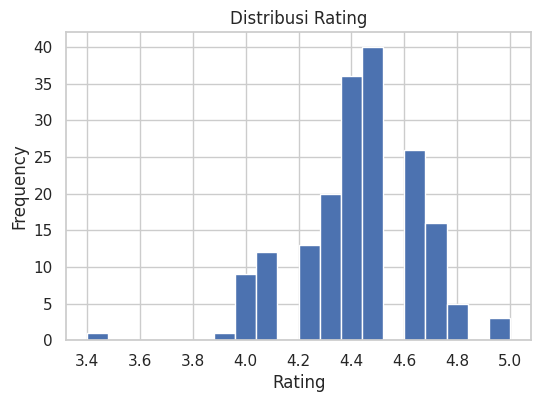

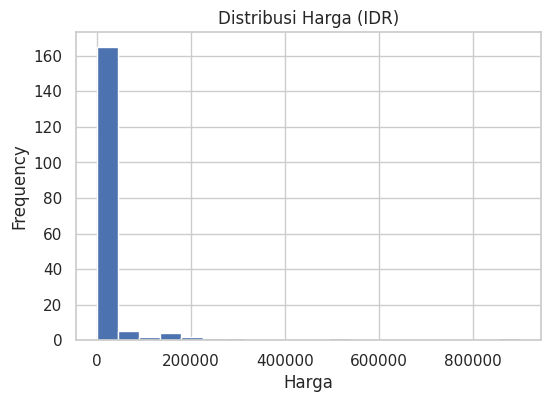

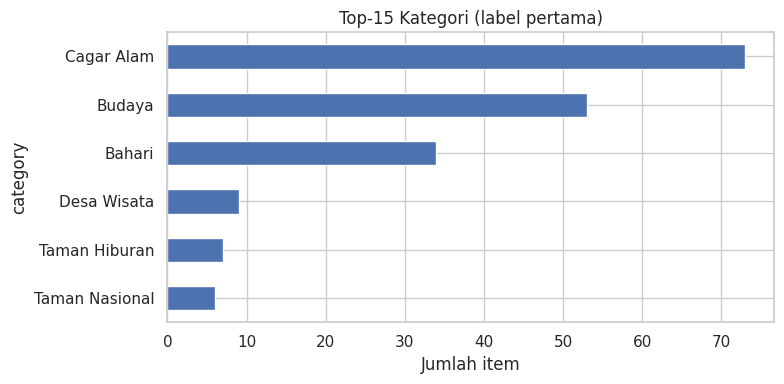

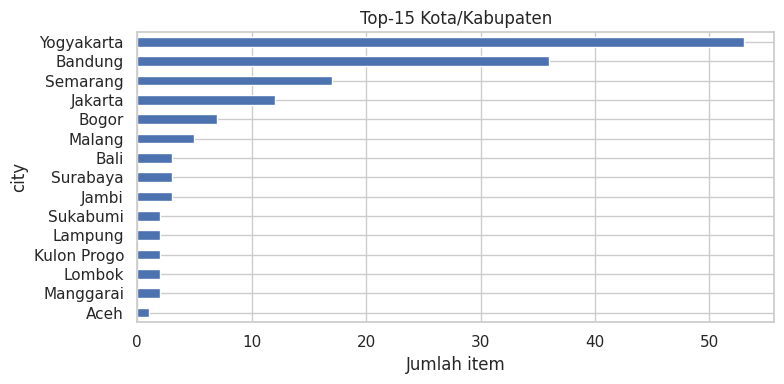

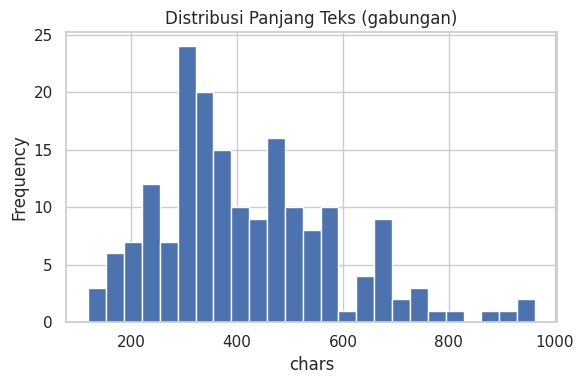

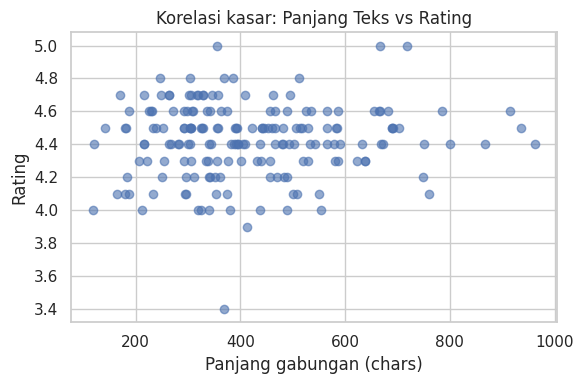

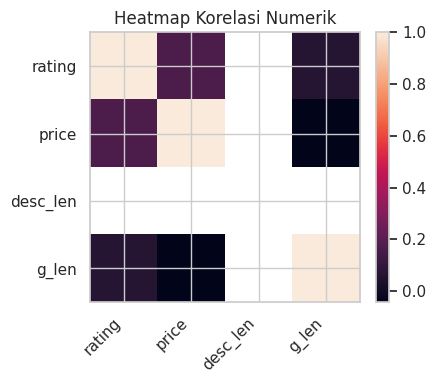

In [6]:
# Ringkasan numerik
print("Jumlah item:", N_ITEMS)
print("\nMissing values per column:")
print(df[["place_name","place_description","category","city","rating","price"]].isna().sum())

# Panjang teks & statistik rating/harga
df["desc_len"] = df["place_description"].astype(str).str.len()
df["g_len"]    = df["gabungan"].astype(str).str.len()
desc_stats = df["desc_len"].describe().to_frame("desc_len")
g_stats    = df["g_len"].describe().to_frame("gabungan_len")
print("\nStat panjang deskripsi:"); print(desc_stats)
print("\nStat panjang gabungan:"); print(g_stats)

# Visualisasi (plt/sns) — gunakan style ggplot
fig, ax = plt.subplots(figsize=(6,4))
df["rating"].astype(float).plot(kind="hist", bins=20, ax=ax, title="Distribusi Rating")
ax.set_xlabel("Rating"); plt.show()

fig, ax = plt.subplots(figsize=(6,4))
df["price"].astype(float).plot(kind="hist", bins=20, ax=ax, title="Distribusi Harga (IDR)")
ax.set_xlabel("Harga"); plt.show()

# Top kategori (ambil label pertama sebelum koma)
cat1 = df["category"].fillna("").apply(lambda s: str(s).split(",")[0].strip())
top_cat = cat1.value_counts().head(15)

fig, ax = plt.subplots(figsize=(8,4))
top_cat.sort_values(ascending=True).plot(kind="barh", ax=ax, title="Top-15 Kategori (label pertama)")
ax.set_xlabel("Jumlah item"); plt.tight_layout(); plt.show()

# Top kota
top_city = df["city"].fillna("").str.strip().value_counts().head(15)
fig, ax = plt.subplots(figsize=(8,4))
top_city.sort_values(ascending=True).plot(kind="barh", ax=ax, title="Top-15 Kota/Kabupaten")
ax.set_xlabel("Jumlah item"); plt.tight_layout(); plt.show()

# Panjang teks
fig, ax = plt.subplots(figsize=(6,4))
df["g_len"].plot(kind="hist", bins=25, ax=ax, title="Distribusi Panjang Teks (gabungan)")
ax.set_xlabel("chars"); plt.tight_layout(); plt.show()

# Korelasi kasar rating vs panjang teks
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df["g_len"], df["rating"], alpha=0.6)
ax.set_title("Korelasi kasar: Panjang Teks vs Rating")
ax.set_xlabel("Panjang gabungan (chars)"); ax.set_ylabel("Rating"); plt.tight_layout(); plt.show()

# Heatmap korelasi numerik
num_cols = [c for c in ["rating","price","desc_len","g_len"] if c in df.columns]
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(corr, interpolation='nearest')
    ax.set_title("Heatmap Korelasi Numerik")
    ax.set_xticks(range(len(num_cols))); ax.set_xticklabels(num_cols, rotation=45, ha='right')
    ax.set_yticks(range(len(num_cols))); ax.set_yticklabels(num_cols)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()


## 4) Query Sintetis untuk Evaluasi

In [7]:
def q_struct_1(r: pd.Series) -> str:
    cat  = str(r.get("category","")).split(",")[0].strip()
    city = str(r.get("city","")).strip()
    name = str(r.get("place_name","")).strip()
    toks = [t for t in [cat, city, name] if t]
    return " ".join(toks)

def q_struct_2(r: pd.Series) -> str:
    cat  = str(r.get("category","")).split(",")[0].strip().lower()
    city = str(r.get("city","")).strip().lower()
    base = "wisata"
    if cat:  base += f" {cat}"
    if city: base += f" di {city}"
    return base.strip()

pairs = []
for i, r in df.iterrows():
    for q in (q_struct_1(r), q_struct_2(r)):
        if q and len(q) >= 3:
            pairs.append((q, int(i)))

random.shuffle(pairs)
print("Total pairs:", len(pairs))

# batasi jumlah query agar evaluasi cepat
MAX_Q = 500
pairs = pairs[:MAX_Q] if MAX_Q else pairs

# Korpus & label item
q_texts = np.array([preprocess_text_simple(q) for q,_ in pairs], dtype=object)
y_idx   = np.array([idx for _,idx in pairs], dtype=np.int64)

# Group-aware split (hindari leakage item antar split)
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, tmp_idx = next(gss1.split(q_texts, y_idx, groups=y_idx))
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_rel_idx, test_rel_idx = next(gss2.split(q_texts[tmp_idx], y_idx[tmp_idx], groups=y_idx[tmp_idx]))

val_idx  = tmp_idx[val_rel_idx]
test_idx = tmp_idx[test_rel_idx]

Q_train, y_train = q_texts[train_idx].tolist(), y_idx[train_idx]
Q_val,   y_val   = q_texts[val_idx].tolist(),   y_idx[val_idx]
Q_test,  y_test  = q_texts[test_idx].tolist(),  y_idx[test_idx]

print("Split sizes -> Train:", len(Q_train), "Val:", len(Q_val), "Test:", len(Q_test))


Total pairs: 364
Split sizes -> Train: 254 Val: 54 Test: 56


## 5) Fitur/Indeks per Metode

In [8]:
art = {}

# TF‑IDF word
vec_word = TfidfVectorizer(max_features=12000, ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True, norm='l2')
X_tfidf_word = vec_word.fit_transform(df["gabungan"])
save_npz(ART_DIR / "tfidf_word.npz", X_tfidf_word.tocsr())
joblib.dump(vec_word, ART_DIR / "vectorizer_word.joblib")
art["tfidf_word"] = (vec_word, X_tfidf_word)

# TF‑IDF char
vec_char = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=2, max_df=0.95, norm='l2')
X_tfidf_char = vec_char.fit_transform(df["gabungan"])
save_npz(ART_DIR / "tfidf_char.npz", X_tfidf_char.tocsr())
joblib.dump(vec_char, ART_DIR / "vectorizer_char.joblib")
art["tfidf_char"] = (vec_char, X_tfidf_char)

# LSI / SVD atas TF‑IDF word
svd = TruncatedSVD(n_components=256, random_state=42)
X_lsi = svd.fit_transform(X_tfidf_word).astype("float32")
joblib.dump(svd, ART_DIR / "svd.joblib")
np.save(ART_DIR / "X_lsi.npy", X_lsi)
art["lsi"] = (svd, X_lsi)

# indeks tetangga TF‑IDF
nbrs = NearestNeighbors(n_neighbors=min(50, len(df)), metric="cosine").fit(X_tfidf_word)
joblib.dump(nbrs, ART_DIR / "nbrs_cosine.joblib")

# BM25
try:
    from rank_bm25 import BM25Okapi
    corpus_tokens = [re.findall(r"\w+", s) for s in df["gabungan"].astype(str).tolist()]
    bm25 = BM25Okapi(corpus_tokens)
    joblib.dump(bm25, ART_DIR / "bm25.joblib")
    art["bm25"] = bm25
    BM25_OK = True
except Exception as e:
    BM25_OK = False
    warnings.warn(f"BM25 tidak aktif: {e}")

# SBERT
try:
    from sentence_transformers import SentenceTransformer
    sbert = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    I_emb = sbert.encode(df["gabungan"].astype(str).tolist(), batch_size=256, show_progress_bar=False, normalize_embeddings=True).astype("float32")
    np.save(ART_DIR / "sbert_item_emb.npy", I_emb)
    art["sbert"] = (sbert, I_emb)
    SBERT_OK = True
except Exception as e:
    SBERT_OK = False
    I_emb = None
    warnings.warn(f"SBERT tidak aktif: {e}")

print("Artifacts built. BM25_OK:", BM25_OK, "| SBERT_OK:", SBERT_OK)


/tmp/ipython-input-1567871317.py:38: UserWarning: BM25 tidak aktif: No module named 'rank_bm25'
  warnings.warn(f"BM25 tidak aktif: {e}")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Artifacts built. BM25_OK: False | SBERT_OK: True


## 6) Rankers per Metode

In [9]:
def scores_tfidf_word(q: str) -> np.ndarray:
    vec, X = art["tfidf_word"]
    qv = vec.transform([q])
    s  = cosine_similarity(X, qv)[:,0]
    return s

def scores_tfidf_char(q: str) -> np.ndarray:
    vec, X = art["tfidf_char"]
    qv = vec.transform([q])
    s  = cosine_similarity(X, qv)[:,0]
    return s

def scores_lsi(q: str) -> np.ndarray:
    vec, Xw = art["tfidf_word"]
    svd, Il = art["lsi"]
    qv = vec.transform([q])
    ql = svd.transform(qv).astype("float32")
    # cosine manual
    s  = (Il @ ql.T).ravel() / (np.linalg.norm(Il, axis=1) * (np.linalg.norm(ql) + 1e-9) + 1e-9)
    return s

def scores_bm25(q: str) -> np.ndarray:
    if "bm25" not in art:
        return np.zeros(len(df), dtype="float32")
    bm25 = art["bm25"]
    qtok = re.findall(r"\w+", q)
    s = np.array(bm25.get_scores(qtok), dtype="float32")
    # normalisasi [0,1] agar sebanding
    if np.max(s) > np.min(s):
        s = (s - np.min(s)) / (np.max(s) - np.min(s))
    return s

def scores_sbert(q: str) -> np.ndarray:
    if "sbert" not in art:
        return np.zeros(len(df), dtype="float32")
    sbert, I = art["sbert"]
    qv = sbert.encode([q], normalize_embeddings=True)
    s  = (I @ qv.T).ravel()
    return s

# UFW di atas TF‑IDF word (centroid pseudo-like: kategori dominan dataset)
top_cat = df["category"].fillna("").apply(lambda s: str(s).split(",")[0].strip())
dom_cat = top_cat.value_counts().index.tolist()[0] if len(top_cat.value_counts()) else ""
LIKED_IDX = df.index[top_cat == dom_cat].tolist()[:max(3, min(10, len(df)//10))]

TFIDF_DENSE = art["tfidf_word"][1].astype("float32").toarray()
def _centroid(indices: List[int]) -> Optional[np.ndarray]:
    if not indices: return None
    C = TFIDF_DENSE[indices].mean(axis=0, keepdims=True)
    n = np.linalg.norm(C) + 1e-9
    return C / n
CENT = _centroid(LIKED_IDX)

def scores_tfidf_ufw(q: str, alpha: float = 0.6) -> np.ndarray:
    base = scores_tfidf_word(q)
    if CENT is None:
        return base
    denom = (np.linalg.norm(TFIDF_DENSE, axis=1) + 1e-9) * (np.linalg.norm(CENT) + 1e-9)
    simc  = (TFIDF_DENSE @ CENT.T).ravel() / denom
    return base + alpha * simc


## 7) Metrik & Evaluasi (dengan Visualisasi)

,Method,P@1,Recall@10,MRR,nDCG@10,Latency(ms/q)
0,TFIDF(char) cosine,0.481481,0.814815,0.613333,0.655922,4.767203
1,TFIDF(word) cosine,0.388889,0.703704,0.519139,0.552855,2.464018
2,LSI(SVD) cosine,0.388889,0.703704,0.519139,0.552855,1.930872
3,TFIDF + UFW(α=0.6),0.296296,0.592593,0.401128,0.435171,4.522716
4,SBERT cosine,0.296296,0.425926,0.338453,0.344659,38.285104


,Method,P@1,Recall@10,MRR,nDCG@10,Latency(ms/q)
0,TFIDF(char) cosine,0.392857,0.767857,0.541353,0.589300,5.583820
1,TFIDF(word) cosine,0.285714,0.714286,0.417151,0.478381,2.465873
2,LSI(SVD) cosine,0.285714,0.714286,0.417151,0.478381,1.530510
3,TFIDF + UFW(α=0.6),0.232143,0.446429,0.310841,0.323517,2.270935
4,SBERT cosine,0.142857,0.375000,0.226807,0.244247,26.905902


/tmp/ipython-input-1378981818.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=30, ha="right")


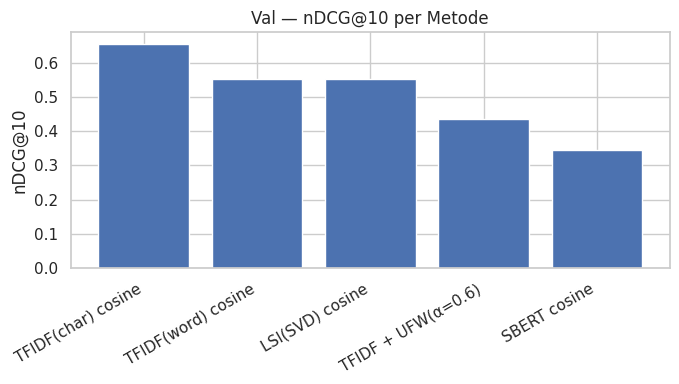

/tmp/ipython-input-1378981818.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=30, ha="right")


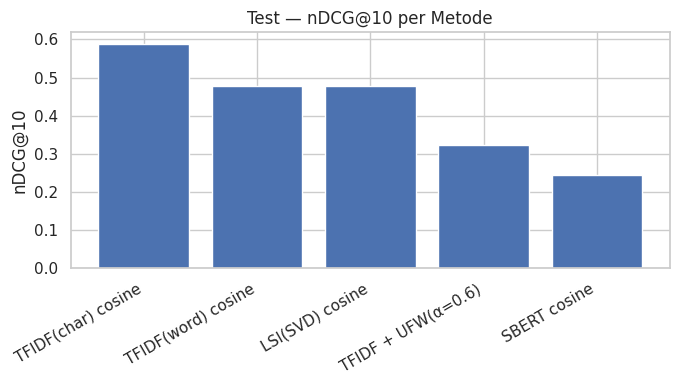

/tmp/ipython-input-1378981818.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=30, ha="right")


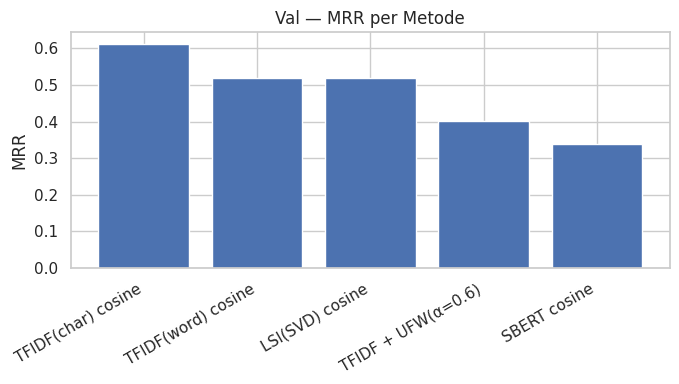

/tmp/ipython-input-1378981818.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=30, ha="right")


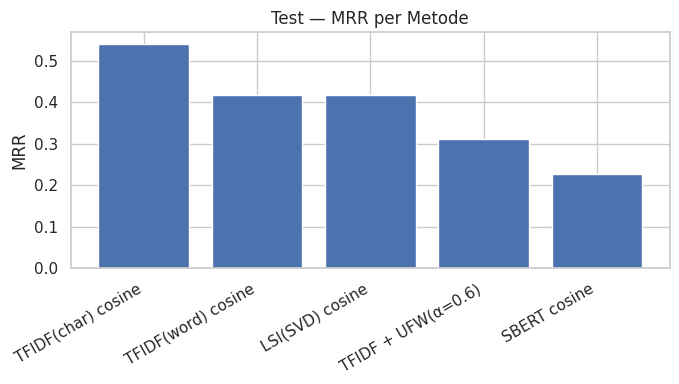

/tmp/ipython-input-1378981818.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=30, ha="right")


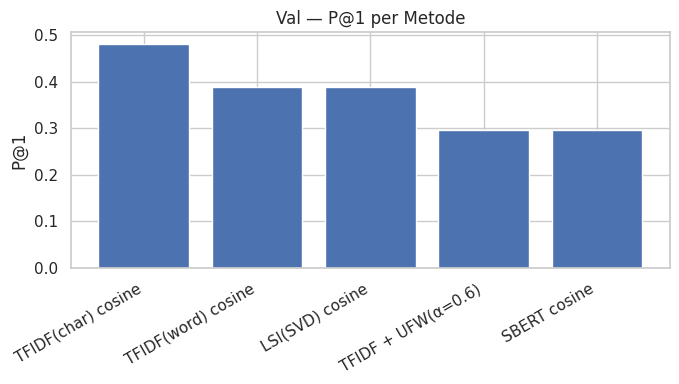

/tmp/ipython-input-1378981818.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=30, ha="right")


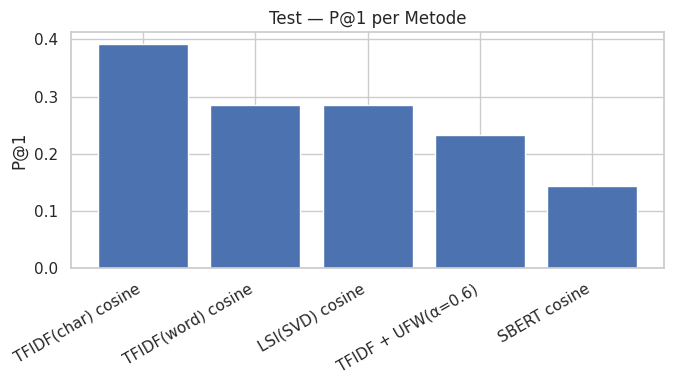

/tmp/ipython-input-1378981818.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=30, ha="right")


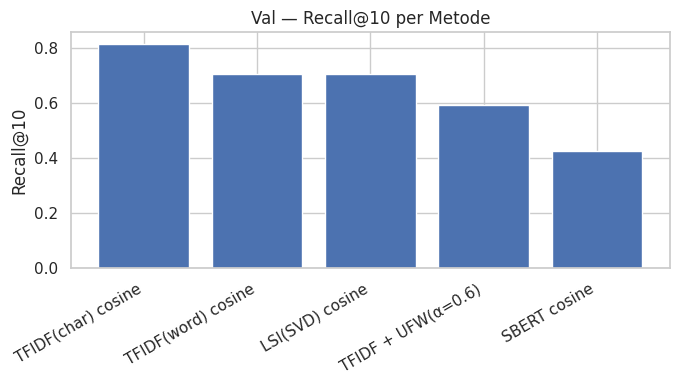

/tmp/ipython-input-1378981818.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=30, ha="right")


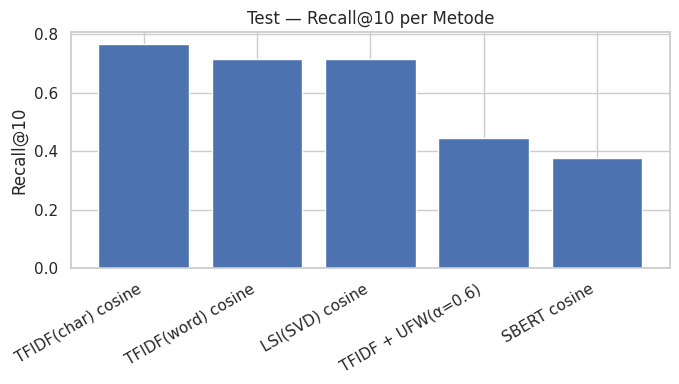

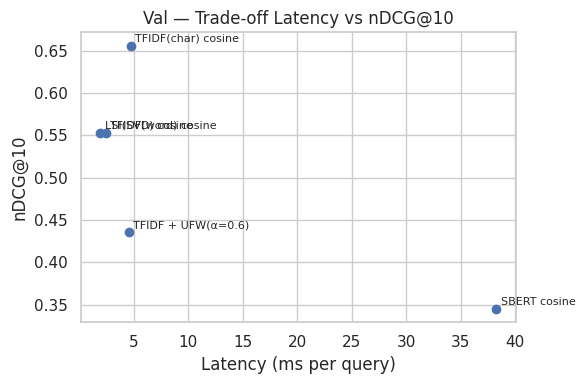

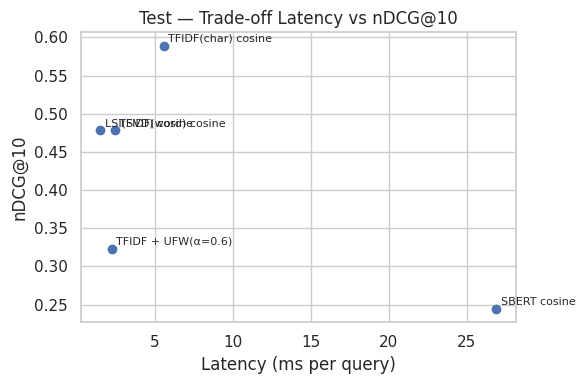

Saved metrics to: artifacts_cbf_bench/metrics.csv


In [10]:
import math, time
from typing import Dict

def precision_at_k(rank: List[int], gt: int, k: int=1) -> float:
    return 1.0 if gt in rank[:k] else 0.0

def recall_at_k(rank: List[int], gt: int, k: int=10) -> float:
    return 1.0 if gt in rank[:k] else 0.0

def mrr(rank: List[int], gt: int) -> float:
    try:
        pos = rank.index(gt); return 1.0 / float(pos + 1)
    except ValueError:
        return 0.0

def ndcg_at_k(rank: List[int], gt: int, k: int=10) -> float:
    try:
        pos = rank[:k].index(gt); return 1.0 / math.log2(pos + 2)
    except ValueError:
        return 0.0

METHODS: Dict[str, callable] = {
    "TFIDF(word) cosine": scores_tfidf_word,
    "TFIDF(char) cosine": scores_tfidf_char,
    "LSI(SVD) cosine":   scores_lsi,
    "BM25":              scores_bm25 if ("bm25" in art) else None,
    "SBERT cosine":      scores_sbert if ("sbert" in art) else None,
    "TFIDF + UFW(α=0.6)": lambda q: scores_tfidf_ufw(q, alpha=0.6),
}

def evaluate_methods(Q_list: List[str], y_true: np.ndarray, methods=METHODS, topk: int=10):
    rows = []
    for name, fn in methods.items():
        if fn is None:
            continue
        t0 = time.perf_counter()
        p1 = r10 = m = nd = 0.0
        for q, gt in zip(Q_list, y_true):
            s = fn(q)
            rank = np.argsort(-s).tolist()
            p1  += precision_at_k(rank, int(gt), 1)
            r10 += recall_at_k(rank, int(gt), 10)
            m   += mrr(rank, int(gt))
            nd  += ndcg_at_k(rank, int(gt), 10)
        ms_per_q = (time.perf_counter() - t0) * 1000.0 / max(1, len(Q_list))
        n = float(len(Q_list))
        rows.append({
            "Method": name,
            "P@1": p1/n, "Recall@10": r10/n, "MRR": m/n, "nDCG@10": nd/n,
            "Latency(ms/q)": ms_per_q
        })
    res = pd.DataFrame(rows).sort_values("nDCG@10", ascending=False).reset_index(drop=True)
    # simpan
    res.to_csv(ART_DIR / 'metrics.csv', index=False)
    return res

res_val  = evaluate_methods(Q_val,  y_val)
res_test = evaluate_methods(Q_test, y_test)

display(res_val); display(res_test)

# ---------- Visualisasi ringkas ----------
def plot_metric_bars(df, metric:str, title:str):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(df["Method"], df[metric])
    ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=30, ha="right")
    plt.tight_layout(); plt.show()

plot_metric_bars(res_val,  "nDCG@10", "Val — nDCG@10 per Metode")
plot_metric_bars(res_test, "nDCG@10", "Test — nDCG@10 per Metode")

plot_metric_bars(res_val,  "MRR", "Val — MRR per Metode")
plot_metric_bars(res_test, "MRR", "Test — MRR per Metode")

plot_metric_bars(res_val,  "P@1", "Val — P@1 per Metode")
plot_metric_bars(res_test, "P@1", "Test — P@1 per Metode")

plot_metric_bars(res_val,  "Recall@10", "Val — Recall@10 per Metode")
plot_metric_bars(res_test, "Recall@10", "Test — Recall@10 per Metode")

# Trade-off Latency vs nDCG
def plot_latency_tradeoff(df, split_name):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(df["Latency(ms/q)"], df["nDCG@10"])
    for i,row in df.iterrows():
        ax.annotate(row["Method"], (row["Latency(ms/q)"], row["nDCG@10"]), fontsize=8, xytext=(3,3), textcoords="offset points")
    ax.set_title(f"{split_name} — Trade‑off Latency vs nDCG@10")
    ax.set_xlabel("Latency (ms per query)"); ax.set_ylabel("nDCG@10")
    plt.tight_layout(); plt.show()

plot_latency_tradeoff(res_val,  "Val")
plot_latency_tradeoff(res_test, "Test")

print("Saved metrics to:", (ART_DIR / 'metrics.csv').as_posix())


## 8) Justifikasi & Rekomendasi Produksi

**Apa itu CBF?**  
CBF bukan satu algoritme tunggal, tetapi **keluarga pendekatan** yang menggunakan **fitur konten** (teks, kategori, lokasi, dsb.) untuk menghitung kemiripan item–query atau item–item. Variasi utamanya ada pada **cara merepresentasikan teks** dan **fungsi kesamaan**.

### Ringkasan Metode
- **TF‑IDF (word/char) + cosine**  
  - **Kelebihan**: cepat, ringan, mudah dituning (ngram, min_df); char‑ngram **tahan typo** & variasi ejaan.  
  - **Kekurangan**: kurang peka sinonim/semantik dalam bahasa natural.
  - **Gunakan ketika**: query cenderung kata kunci; kecepatan krusial; data tidak terlalu besar.
- **BM25**  
  - **Kelebihan**: efektif untuk dokumen panjang; pembobotan tf/idf yang lebih robust.  
  - **Kekurangan**: perlu modul tambahan; scaling mirip TF‑IDF.  
  - **Gunakan ketika**: deskripsi teks panjang, query keyword style.
- **LSI / TruncatedSVD (dense) + cosine**  
  - **Kelebihan**: memproyeksikan ke ruang topik laten → **lebih toleran sinonim ringan**; vektor item **dense** sehingga ANN jadi mudah.  
  - **Kekurangan**: masih linear, tidak sekuat model semantik modern.  
  - **Gunakan ketika**: ingin kompromi akurasi vs kecepatan; butuh vektor dense kecil.
- **SBERT (sentence embeddings) + cosine**  
  - **Kelebihan**: menangkap **semantik kalimat** dan sinonim lebih baik.  
  - **Kekurangan**: **latensi encode** lebih tinggi; memori item embeddings lebih besar.  
  - **Gunakan ketika**: query berbentuk bahasa natural; kualitas > latensi.
- **TF‑IDF + UFW (centroid Like)**  
  - **Kelebihan**: **personalisasi ringan** tanpa akun/login; mudah ditambahkan.  
  - **Kekurangan**: butuh *feedback* yang cukup; dapat bias ke kategori dominan.  
  - **Gunakan ketika**: aplikasi dengan Like/Skip; ingin meningkatkan relevansi tanpa CF.

### Tips Produksi
- **Diversifikasi & Serendipity**: gunakan MMR untuk menghindari *overspecialization*.  
- **ANN Index (FAISS/HNSW)** untuk skala besar (jutaan item) terutama pada vektor dense (SVD/SBERT).  
- **Caching**: cache embedding query yang populer; precompute & simpan **item embeddings**.  
- **Filter & Bisnis Rules**: tegakkan batas harga, lokasi, jam buka, dsb. sebelum ranking final.  
- **A/B Testing**: bandingkan nDCG@K & CTR; monitor latensi  P95.  
- **Hybrid**: kombinasikan CBF dengan sinyal klik/rating (re‑ranking) atau CF ringan bila data cukup.

> **Rekomendasi awal**: mulai dari **TF‑IDF(word)+char + UFW + MMR**. Jika query natural-language dominan, pertimbangkan **SBERT**. Untuk skala dan kecepatan, proyeksikan TF‑IDF→**SVD** untuk vektor dense + **ANN**.
